# Exploratory Data Analysis



## Data Load

In [2]:
#required imports for the data analysis
import sqlite3
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gspec
import seaborn as sns

In [3]:
#setup connection to the database

mypath="D:\\Documents\\University\\7_semestre\\DM\\Project\\DataMiningFinalProject\\Data\\insurance.db"
conn=sqlite3.connect(mypath)
cursor=conn.cursor()

In [4]:
#Get information about tables from db
cursor.execute("SELECT sql FROM sqlite_master WHERE type='table';")
tables=pd.DataFrame(cursor.fetchall(), columns=[d[0] for d in cursor.description])

table_variables=[]
for i in tables.iloc[:,0]:
    table_variables.append([j.group().replace("\"", '') for j in re.finditer('\".*\"',i)])

table_variables

[['LOB',
  'index',
  'Customer Identity',
  'Premiums in LOB: Motor',
  'Premiums in LOB: Household',
  'Premiums in LOB: Health',
  'Premiums in LOB:  Life',
  'Premiums in LOB: Work Compensations'],
 ['Engage',
  'index',
  'Customer Identity',
  'First Policy´s Year',
  'Brithday Year',
  'Educational Degree',
  'Gross Monthly Salary',
  'Geographic Living Area',
  'Has Children (Y=1)',
  'Customer Monetary Value',
  'Claims Rate']]

## Data Assessment 

In [5]:
#Build Analytical Base Table (ABT)
abtquery="""SELECT e.'Customer Identity', e.'First Policy´s Year', e.'Brithday Year', e.'Educational Degree', 
            e.'Gross Monthly Salary', e.'Geographic Living Area', e.'Has Children (Y=1)', e.'Customer Monetary Value', 
            e.'Claims Rate', l.'Premiums in LOB: Motor', l.'Premiums in LOB: Household', l.'Premiums in LOB: Health', 
            l.'Premiums in LOB:  Life', l.'Premiums in LOB: Work Compensations'
            FROM LOB l, Engage e
            WHERE l.'Customer Identity'=e.'Customer Identity'"""
cursor.execute(abtquery)

df=pd.DataFrame(cursor.fetchall(), columns=[d[0] for d in cursor.description])
conn.close()
df.head()

,Customer Identity,First Policy´s Year,Brithday Year,Educational Degree,Gross Monthly Salary,Geographic Living Area,Has Children (Y=1),Customer Monetary Value,Claims Rate,Premiums in LOB: Motor,Premiums in LOB: Household,Premiums in LOB: Health,Premiums in LOB: Life,Premiums in LOB: Work Compensations
0,1,1985.0,1982.0,2 - High School,2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2,1981.0,1995.0,2 - High School,677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3,1991.0,1970.0,1 - Basic,2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4,1990.0,1981.0,3 - BSc/MSc,1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5,1986.0,1973.0,3 - BSc/MSc,1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [6]:
#Dimension of the dataset
df.shape

(10296, 14)

In [7]:
#Data types of the variables
df.dtypes

Customer Identity                        int64
First Policy´s Year                    float64
Brithday Year                          float64
Educational Degree                      object
Gross Monthly Salary                   float64
Geographic Living Area                 float64
Has Children (Y=1)                     float64
Customer Monetary Value                float64
Claims Rate                            float64
Premiums in LOB: Motor                 float64
Premiums in LOB: Household             float64
Premiums in LOB: Health                float64
Premiums in LOB:  Life                 float64
Premiums in LOB: Work Compensations    float64
dtype: object

In [8]:
#Correcting some data types
df=df.astype({"Geographic Living Area": object, "Has Children (Y=1)": object})

In [9]:
#Get summary statistics from df
df.describe(include='all')

,Customer Identity,First Policy´s Year,Brithday Year,Educational Degree,Gross Monthly Salary,Geographic Living Area,Has Children (Y=1),Customer Monetary Value,Claims Rate,Premiums in LOB: Motor,Premiums in LOB: Household,Premiums in LOB: Health,Premiums in LOB: Life,Premiums in LOB: Work Compensations
count,10296.00000,10266.000000,10279.000000,10279,10260.000000,10295.0,10275.0,10296.000000,10296.000000,10262.000000,10296.000000,10253.000000,10192.000000,10210.000000
unique,NaN,NaN,NaN,4,NaN,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,3 - BSc/MSc,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,4799,NaN,4145.0,7262.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5148.50000,1991.062634,1968.007783,NaN,2506.667057,NaN,NaN,177.892605,0.742772,300.470252,210.431192,171.580833,41.855782,41.277514
std,2972.34352,511.267913,19.709476,NaN,1157.449634,NaN,NaN,1945.811505,2.916964,211.914997,352.595984,296.405976,47.480632,51.513572
min,1.00000,1974.000000,1028.000000,NaN,333.000000,NaN,NaN,-165680.420000,0.000000,-4.110000,-75.000000,-2.110000,-7.000000,-12.000000
25%,2574.75000,1980.000000,1953.000000,NaN,1706.000000,NaN,NaN,-9.440000,0.390000,190.590000,49.450000,111.800000,9.890000,10.670000
50%,5148.50000,1986.000000,1968.000000,NaN,2501.500000,NaN,NaN,186.870000,0.720000,298.610000,132.800000,162.810000,25.560000,25.670000
75%,7722.25000,1992.000000,1983.000000,NaN,3290.250000,NaN,NaN,399.777500,0.980000,408.300000,290.050000,219.820000,57.790000,56.790000


In [10]:
#More info about df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
Customer Identity                      10296 non-null int64
First Policy´s Year                    10266 non-null float64
Brithday Year                          10279 non-null float64
Educational Degree                     10279 non-null object
Gross Monthly Salary                   10260 non-null float64
Geographic Living Area                 10295 non-null object
Has Children (Y=1)                     10275 non-null object
Customer Monetary Value                10296 non-null float64
Claims Rate                            10296 non-null float64
Premiums in LOB: Motor                 10262 non-null float64
Premiums in LOB: Household             10296 non-null float64
Premiums in LOB: Health                10253 non-null float64
Premiums in LOB:  Life                 10192 non-null float64
Premiums in LOB: Work Compensations    10210 non-null float64
dtypes: float64(10), int64(1

In [9]:
#Check duplicates
any(df.duplicated())

False

In [10]:
#Number of missing values in each feature
df.isna().sum()

Customer Identity                        0
First Policy´s Year                     30
Brithday Year                           17
Educational Degree                      17
Gross Monthly Salary                    36
Geographic Living Area                   1
Has Children (Y=1)                      21
Customer Monetary Value                  0
Claims Rate                              0
Premiums in LOB: Motor                  34
Premiums in LOB: Household               0
Premiums in LOB: Health                 43
Premiums in LOB:  Life                 104
Premiums in LOB: Work Compensations     86
dtype: int64

In [11]:
#Frequencies of number of missing values across rows
df.isna().apply(lambda x:sum(x), axis=1).value_counts().sort_index()

0    9987
1     256
2      38
3       3
4      12
dtype: int64

## Data Visualizations

<img src="./img/anatomy_of_figure.png"/>

In [17]:
#Define metric and non-metric datasets
metric= df.loc[:,(df.columns=="Customer Identity") | (np.array(df.dtypes=="float64"))]
non_metric= df.loc[:,(df.columns=="Customer Identity") | (np.array(df.dtypes=="object"))]

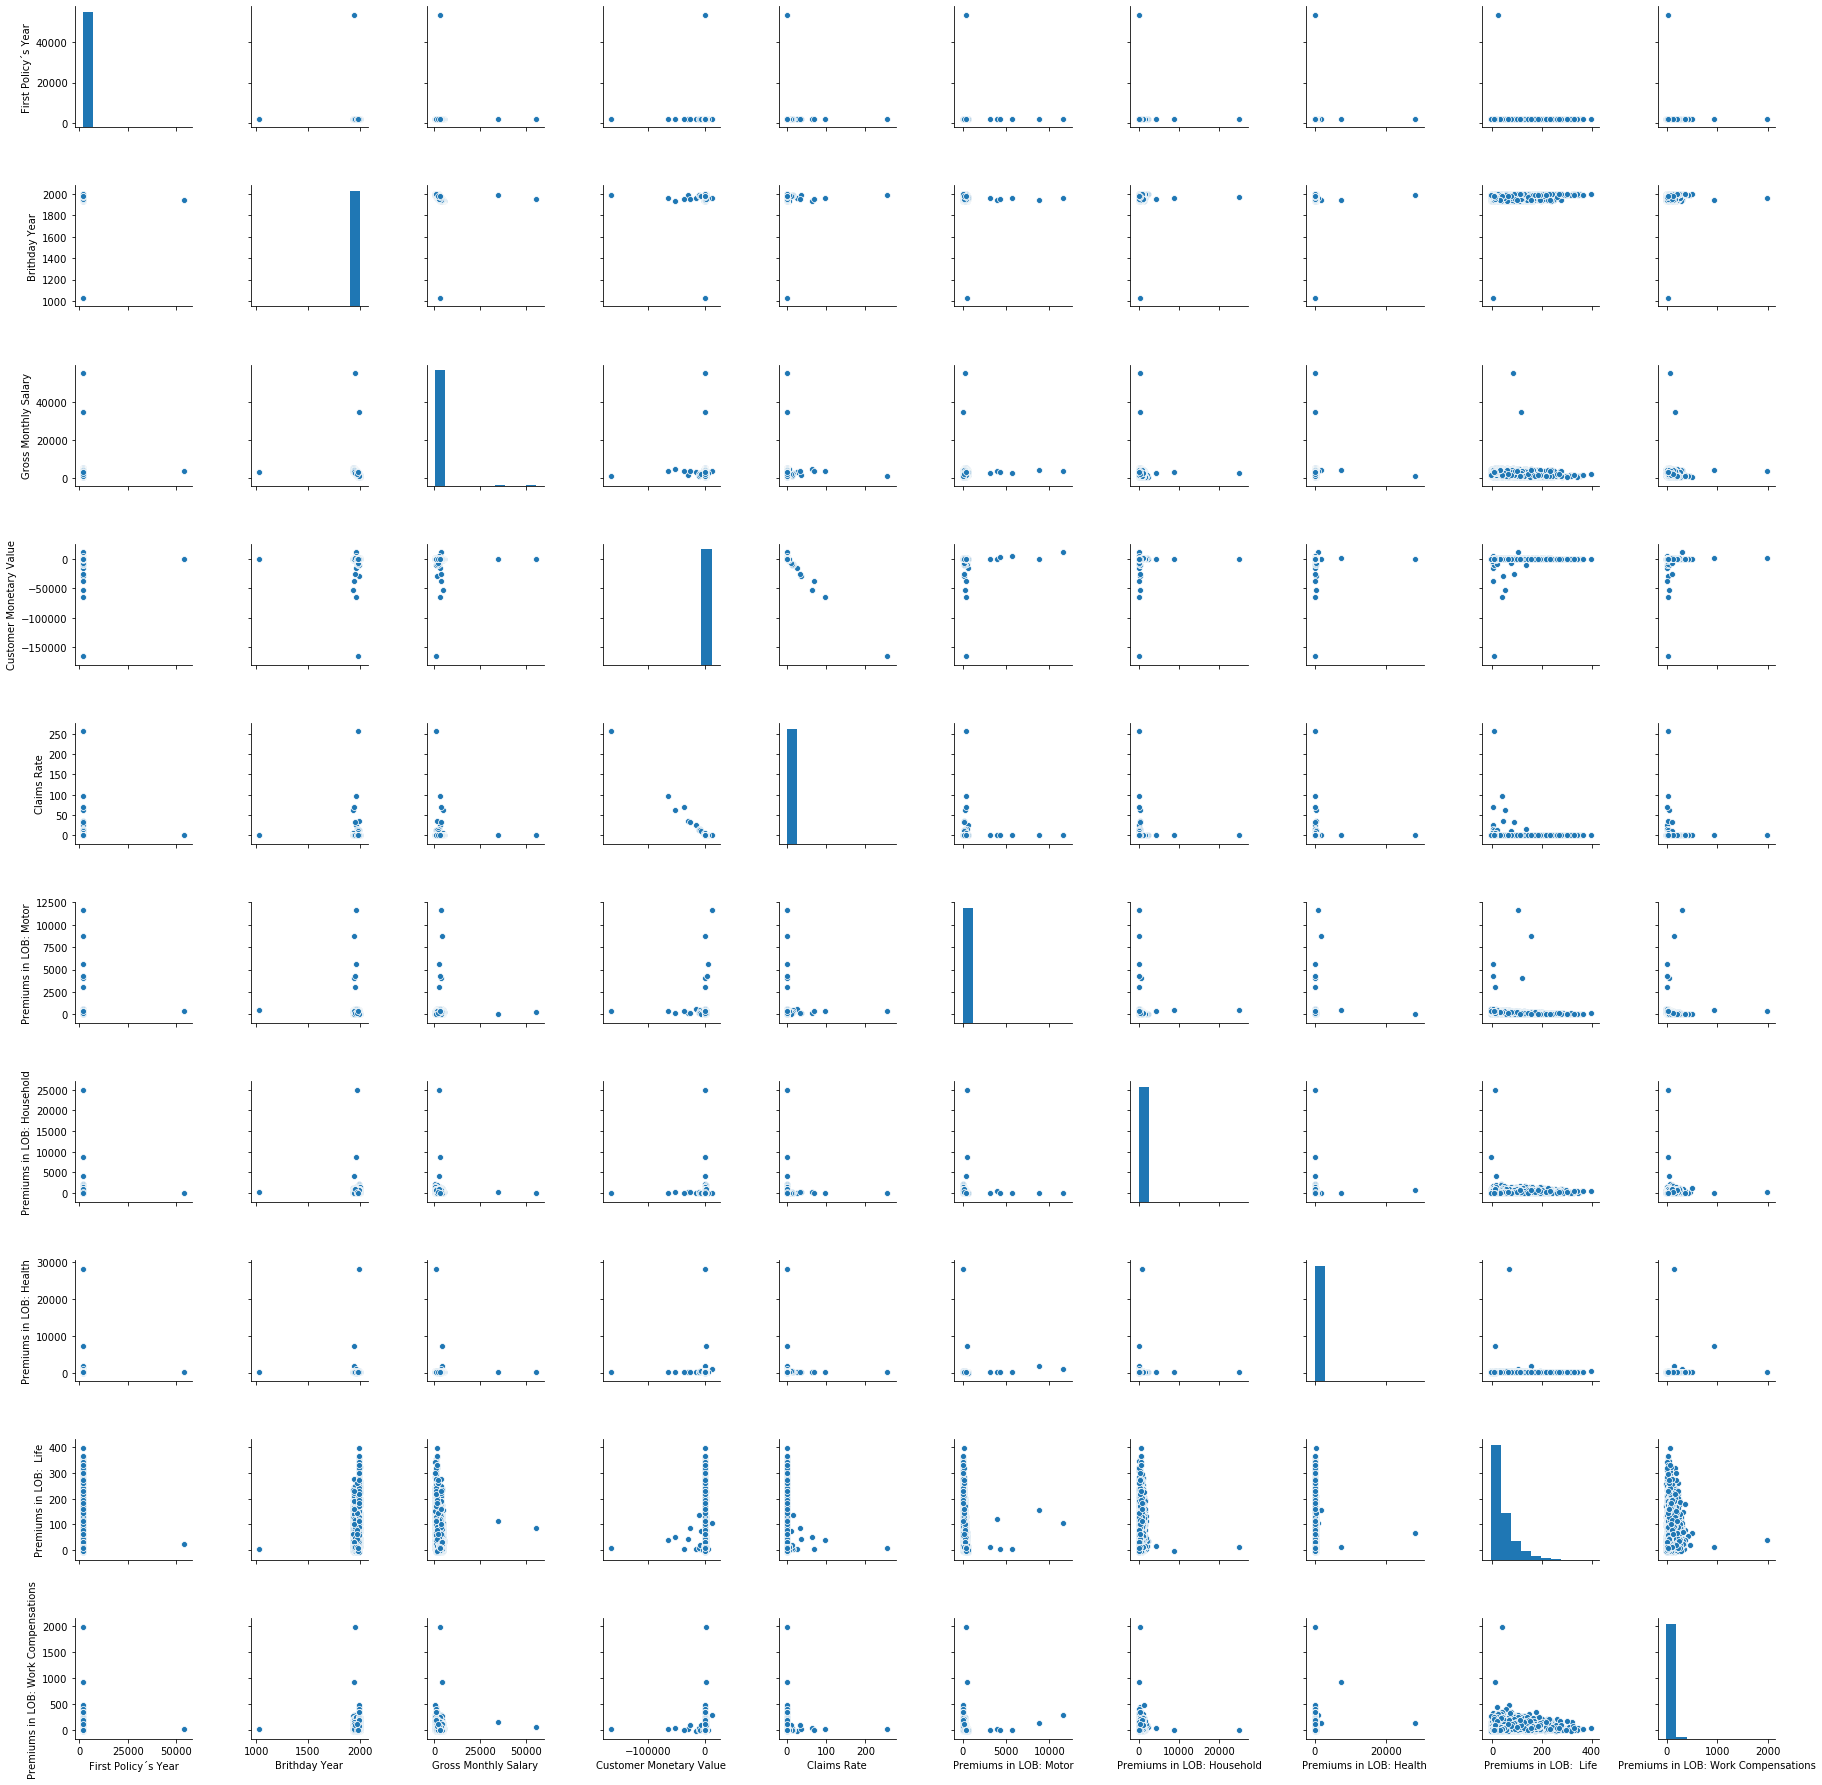

In [15]:
sns.pairplot(metric.drop("Customer Identity",1))
plt.show()

C:\Users\davids\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


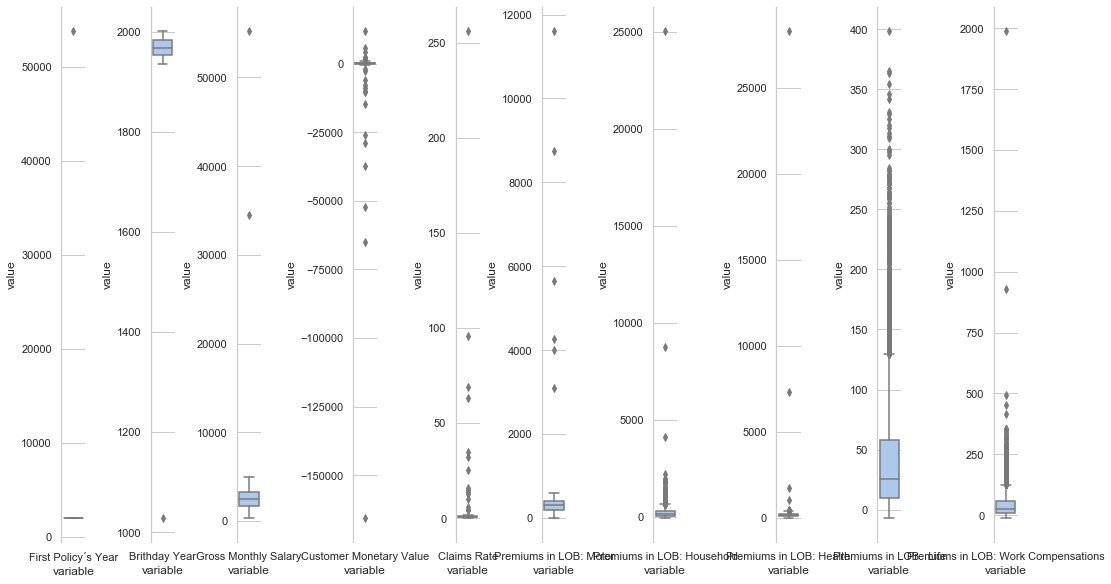

In [16]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# Prepare dataframe layout
data=metric.melt("Customer Identity")
plot_features= metric.drop("Customer Identity",1).columns

#Prepare figure layout
fig= plt.figure(constrained_layout=True) #Create figure object
spec= gspec.GridSpec(ncols=len(plot_features), nrows=1, figure=fig) #Gridspec allows to define the grid structure which can  
                                                                    #then be populated through figure.add_subplot method
    
# Draw the violinplots and split the violins for easier comparison
for i, plot_f in enumerate(plot_features):
    ax= fig.add_subplot(spec[0,i])
    pdata= data.loc[data.loc[:,"variable"]==plot_f,:]
#     viol_df.loc[viol_df.loc[:,"variable"]==plot_f,:] #Selecting every variable-value pair for a specific metric variable
    graph= sns.boxplot(x="variable", y="value", data=pdata, ax=ax)

# Finalize the plot
sns.despine(bottom=True)
fig.set_size_inches(15, 8)

plt.show()

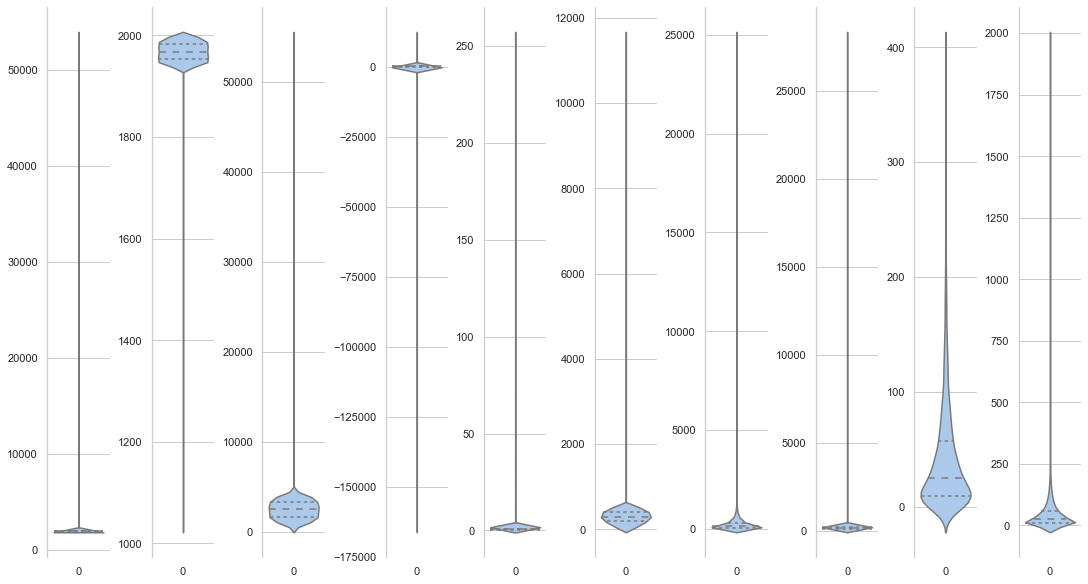

In [92]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# Prepare dataframe layout
# viol_df= metric.melt(id_vars= "Customer Identity") #melt function unpivots dataframe into variable-value pairs identified by an id
plot_features= metric.drop("Customer Identity",1).columns

#Prepare figure layout
fig= plt.figure(constrained_layout=True) #Create figure object
spec= gspec.GridSpec(ncols=len(plot_features), nrows=1, figure=fig) #Gridspec allows to define the grid structure which can  
                                                                    #then be populated through figure.add_subplot method
    
# Draw the violinplots and split the violins for easier comparison
for i, plot_f in enumerate(plot_features):
    ax= fig.add_subplot(spec[0,i])
    data= metric.drop("Customer Identity",1).loc[:,plot_f]
#     viol_df.loc[viol_df.loc[:,"variable"]==plot_f,:] #Selecting every variable-value pair for a specific metric variable
    graph= sns.violinplot( inner="quart", data=data, ax=ax, )

# Finalize the plot
sns.despine(bottom=True)
fig.set_size_inches(15, 8)

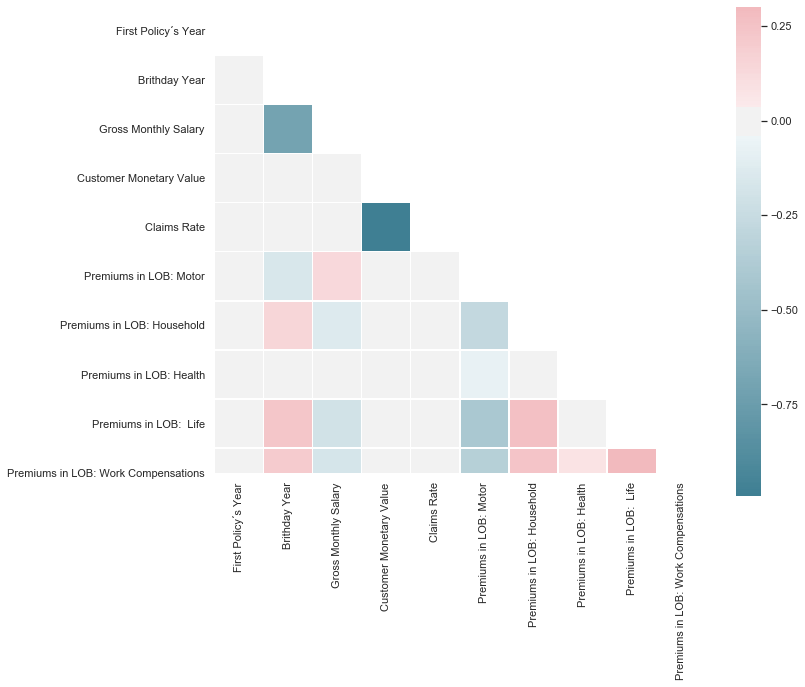

In [70]:
sns.set(style="white")

# Compute the correlation matrix
corr = metric.drop("Customer Identity",1).corr() #Getting correlation of numerical variables

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5)

plt.show()